In [8]:
import numpy
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import hamming_loss
import matplotlib.pyplot as plt
from utils import *
import keras.backend as K
K.set_image_data_format('channels_last')

In [2]:
x_train, x_test, y_train, y_test = load_dataset()
x_train = x_train / 255.
x_test = x_test / 255.

In [3]:
y = np.concatenate((y_train, y_test))
dict = {}
for i in range(y.shape[0]):
    key = np.array2string(y[i, :])
    if key in dict.keys():
        dict[key] += 1
    else:
        dict[key] = 1

for key in dict.keys():
    labels = []
    for i in range(1, 10, 2):
        if key[i] == '1':
            labels.append(class_labels[int((i-1)/2)])
    print(str(labels) + ':' + str(dict[key]))

['sea', 'sunset']:344
['sea']:682
['desert', 'trees']:40
['desert', 'sunset']:42
['mountains']:536
['desert', 'mountains', 'sunset']:2
['mountains', 'trees']:212
['desert', 'sea']:10
['mountains', 'sea', 'trees']:12
['mountains', 'sunset']:38
['mountains', 'sunset', 'trees']:2
['sunset']:432
['desert']:680
['sunset', 'trees']:56
['desert', 'mountains']:38
['sea', 'trees']:28
['desert', 'sunset', 'trees']:6
['mountains', 'sea']:76
['sea', 'sunset', 'trees']:8
['trees']:756


In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('sigmoid'))

### [loss function for multi-label problem](https://github.com/keras-team/keras/issues/2166)

In [ ]:
opt = keras.optimizers.adam(lr=0.0001, decay=1e-6)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=32, epochs=25)

Epoch 1/25
3200/3200 [==============================] - 159s 50ms/step - loss: 0.4987 - acc: 0.7734

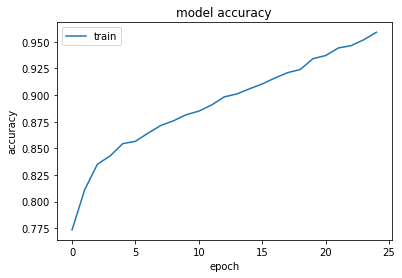

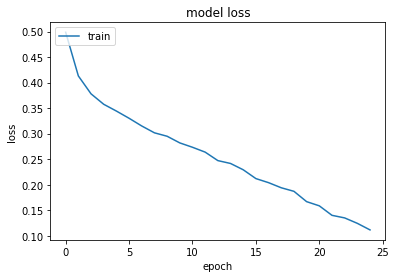

In [14]:
# summarize history for accuracy
plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [11]:
y_prob = model.predict_proba(x_test)
print('mean proba of every label:', np.mean(np.array(y_prob), axis=0))
print('variance proba of every label:', np.var(np.array(y_prob), axis=0))
print('minimum proba of every label:', np.amin(np.array(y_prob), axis=0))
print('maximum proba of every label:', np.amax(np.array(y_prob), axis=0))

mean proba of every label: [0.21598439 0.21690416 0.23674126 0.22916122 0.27322242]
variance proba of every label: [0.11707339 0.11148663 0.09913059 0.14191502 0.14439476]
minimum proba of every label: [1.2837602e-16 3.5439289e-15 6.9095981e-14 8.4615178e-15 5.2868486e-06]
maximum proba of every label: [0.9999813  0.9999751  0.99941254 0.99997854 1.        ]


In [12]:
threshold = np.arange(0.01, 0.9, 0.01)
best_threshold = np.zeros(num_classes)
acc = []
for i in range(num_classes):
    y_prob_i = np.array(y_prob[:, i])
    for j in threshold:
        y_pred_i = [1 if prob >= j else 0 for prob in y_prob_i]
        acc.append(matthews_corrcoef(y_test[:, i], y_pred_i))
    index = np.argmax(np.array(acc))
    best_threshold[i] = threshold[index]
    acc = []

In [13]:
print ("best thresholds: ", best_threshold)
y_pred = np.array([[1 if y_prob[i,j] >= best_threshold[j] else 0 for j in range(num_classes)] for i in range(len(y_test))])
print('hamming_loss: ', hamming_loss(y_test, y_pred))

best thresholds:  [0.65 0.25 0.37 0.48 0.69]
hamming_loss:  0.11875


In [ ]:
model.save('./my_model.h5')